In [1]:
import numpy as np
import plotly.graph_objects as go               # More plotly libs

## TOMASI KANADE FACTORIZATION

## TEST ON THE HOTEL DATASET

In [2]:
def read_measurement_matrix(path):
    with open(path) as file:
        content = file.readlines()  

    for i in range(len(content)):
        row = content[i]
        row = row.strip().split()
        row = list(map(lambda x: float(x), row))
        content[i] = row
    return np.array(content)

In [3]:
W_alternating = read_measurement_matrix("illinois/factorization_data/measurement_matrix.txt")
num_frames, num_features = W_alternating.shape
num_frames//=2
num_frames
# num_features

101

In [4]:
def group_ij(M):
    Wx = M[::2]
    Wy = M[1::2]
    num_frames = M.shape[0]//2
    W =np.zeros_like(M)
    W[:num_frames] = Wx
    W[num_frames:] = Wy
    return W

def alternate_ij(M):
    M_alternating = np.zeros_like(M)
    size = M.shape[0]
    assert size%2==0
    halfsize = size//2

    M_i = M[:halfsize]
    M_j = M[halfsize:]
    for i in range(halfsize):
        M_alternating[2*i] = M_i[i]
        M_alternating[2*i+1] = M_j[i]

    return M_alternating

In [5]:
W = group_ij(W_alternating)


In [23]:
def find_initial_guess(W):
    W_CENTERED = W - np.atleast_2d(W.mean(axis=1)).T
    U, SIG_FLAT, VT = np.linalg.svd(W_CENTERED, full_matrices=False)

    # change rank to 3
    U = U[:,:3]
    SIG = np.diag(SIG_FLAT)[:3,:3]
    VT = VT[:3,:]

    # Compute the initial guess for the motion and structure matrices
    MHAT = U @ np.sqrt(SIG)
    SHAT = np.sqrt(SIG) @ VT

    return MHAT, SHAT, SIG_FLAT

In [24]:
MHAT, SHAT, SIGFLAT = find_initial_guess(W)

In [25]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Top 15 Singular Values of the observation matrix')

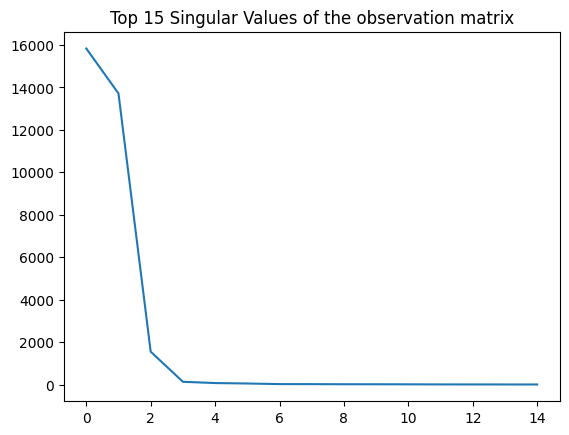

In [31]:
plt.plot(SIGFLAT[:15])
plt.title("Top 15 Singular Values of the observation matrix")

In [32]:
sum(SIGFLAT[:3])/sum(SIGFLAT)

0.9837835970705785

In [8]:
num_frames

101

In [9]:
MHAT_i = MHAT[:num_frames]
MHAT_j = MHAT[num_frames:]

In [10]:
def compute_QQT(MHAT:np.ndarray):
    num_frames = MHAT.shape[0]//2
    MHAT_i = MHAT[:num_frames]
    MHAT_j = MHAT[num_frames:]
    
    # We will find the entries of QQ^T by setting up a system of 
    # equations for each entry 
    A = np.zeros((3*num_frames, 6))
    b = np.zeros(3*num_frames)
    b[:2*num_frames] = 1



    for i in range(num_frames):

        # The proper i vectors have norm 1
        A[i, 0] = MHAT_i[i,0]**2
        A[i, 1] = 2 * MHAT_i[i,0]* MHAT_i[i,1]
        A[i, 2] = 2 * MHAT_i[i,0]* MHAT_i[i,2]
        A[i, 3] = MHAT_i[i,1]**2
        A[i, 4] = 2 * MHAT_i[i,2]* MHAT_i[i,2]
        A[i, 5] = MHAT_i[i,2]**2

        # The proper j vectors have norm 1

        A[num_frames + i, 0] = MHAT_j[i,0]**2
        A[num_frames + i, 1] = 2 * MHAT_j[i,0]* MHAT_j[i,1]
        A[num_frames + i, 2] = 2 * MHAT_j[i,0]* MHAT_j[i,2]
        A[num_frames + i, 3] = MHAT_j[i,1]**2
        A[num_frames + i, 4] = 2 * MHAT_j[i,2]* MHAT_j[i,2]
        A[num_frames + i, 5] = MHAT_j[i,2]**2

        # The i and j vectors are orthogonal and thus the dot is 0
        A[2 * num_frames + i, 0] = MHAT_i[i,0] * MHAT_j[i,0]
        A[2 * num_frames + i, 1] = MHAT_i[i,0] *  MHAT_j[i,1] + MHAT_i[i,1] *  MHAT_j[i,0]
        A[2 * num_frames + i, 2] = MHAT_i[i,0] *  MHAT_j[i,2] + MHAT_i[i,2] *  MHAT_j[i,2]
        A[2 * num_frames + i, 3] = MHAT_i[i,1] * MHAT_j[i,1]
        A[2 * num_frames + i, 4] = MHAT_i[i,1] *  MHAT_j[i,2] + MHAT_i[i,2] *  MHAT_j[i,1]
        A[2 * num_frames + i, 5] = MHAT_i[i,2] * MHAT_j[i,2]
    
    qqt_entries, residuals, rank, singular_vals = np.linalg.lstsq(A,b, rcond= None)


    # Assemble QQT
    QQT = np.zeros((3,3))

    QQT[0,0] = qqt_entries[0]
    QQT[1,1] = qqt_entries[3]
    QQT[2,2] = qqt_entries[5]

    QQT[0,1] = qqt_entries[1]
    QQT[1,0] = qqt_entries[1]

    QQT[0,2] = qqt_entries[2]
    QQT[2,0] = qqt_entries[2]

    QQT[1,2] = qqt_entries[4]
    QQT[2,1] = qqt_entries[4]

    return QQT, residuals, rank, singular_vals
    



In [11]:
QQT, residuals, rank, singular_vals = compute_QQT(MHAT)

In [12]:
residuals

array([0.18373474])

In [13]:
QQT

array([[6.35596288e-03, 6.49826467e-05, 1.06886461e-04],
       [6.49826467e-05, 7.18744988e-03, 6.64723700e-05],
       [1.06886461e-04, 6.64723700e-05, 1.56337101e-03]])

In [14]:
# Test whether the QQT actually works
print(MHAT_i[5].T @ QQT @ MHAT_i[5])
print(MHAT_j[2].T @ QQT @ MHAT_j[2])
print(MHAT_i[2].T @ QQT @ MHAT_j[2])
# Good enough, 

0.9365265706564595
0.9679660695320583
0.0004079116583850517


In [ ]:
import matplotlib.pyplot as plt

plt.plot(singular_vals, )

In [15]:
# Find Q and compute the actual object points

Q = np.linalg.cholesky(QQT)
QINV = np.linalg.inv(Q)

# Assemble final guess for Motion and Structure.
M = MHAT @ Q
S = QINV @ SHAT



In [16]:
# test whether the norms of the motion matrix are close to 1
np.linalg.norm(M, axis=1).mean()

0.9989407455332266

In [17]:
def compute_object_points(SHAT, QQT=None, Q=None, normalize_size = False):
    if QQT is None and Q is None:
        print("You must give either the QQT or the Q")

    if Q is None:
        Q = np.linalg.cholesky(QQT)
    
    QINV = np.linalg.inv(Q)

    # Assemble final guess for Motion and Structure.
    S = QINV @ SHAT
    
    if normalize_size:
        S = S / np.linalg.norm(S, axis=1).mean()
    return S

In [18]:
S = compute_object_points(SHAT, QQT)

In [19]:
def normalize_object_size(S):
    return S / np.linalg.norm(S, axis=1).mean()

In [20]:
def visualize_points(S):
    X = S[0]
    Y = S[1]
    Z = S[2]

    object_points = go.Scatter3d(x=X, y=Y, z=-Z, mode='markers', marker=dict(size=2, color=-Z, colorscale='Viridis', opacity=0.8))

    fig = go.Figure(data=[object_points])
    fig.update_layout(title='3D Point Cloud from TK Factorization', autosize=False, width=800, height=800, margin=dict(l=65, r=50, b=65, t=90))
    fig.show()


In [21]:
visualize_points(S)